# Deep Learning Models Implementation

## Imports

In [ ]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Input, SimpleRNN
from tensorflow.keras.models import Sequential

from transformers import AutoModelForSequenceClassification, AutoTokenizer, PreTrainedTokenizer, BertModel, TrainerCallback, EvalPrediction, TrainingArguments, Trainer

import torch
from torch.utils.data.dataset import Dataset

import warnings
warnings.filterwarnings("ignore")

In [4]:
csv.field_size_limit(10**7)

131072

## Preprocessing

Load dataset

In [5]:
initial_df = pd.read_csv("../data/SpamAssasin.csv", encoding="utf-8", engine='python')
df = initial_df.copy()

df.head()

,sender,receiver,date,subject,body,label,urls
0,Robert Elz <kre@munnari.OZ.AU>,Chris Garrigues <cwg-dated-1030377287.06fa6d@D...,"Thu, 22 Aug 2002 18:26:25 +0700",Re: New Sequences Window,"Date: Wed, 21 Aug 2002 10:54:46 -0500 ...",0,1
1,Steve Burt <Steve_Burt@cursor-system.com>,"""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoo...","Thu, 22 Aug 2002 12:46:18 +0100",[zzzzteana] RE: Alexander,"Martin A posted:\nTassos Papadopoulos, the Gre...",0,1
2,"""Tim Chapman"" <timc@2ubh.com>",zzzzteana <zzzzteana@yahoogroups.com>,"Thu, 22 Aug 2002 13:52:38 +0100",[zzzzteana] Moscow bomber,Man Threatens Explosion In Moscow \n\nThursday...,0,1
3,Monty Solomon <monty@roscom.com>,undisclosed-recipient: ;,"Thu, 22 Aug 2002 09:15:25 -0400",[IRR] Klez: The Virus That Won't Die,Klez: The Virus That Won't Die\n \nAlready the...,0,1
4,Stewart Smith <Stewart.Smith@ee.ed.ac.uk>,zzzzteana@yahoogroups.com,"Thu, 22 Aug 2002 14:38:22 +0100",Re: [zzzzteana] Nothing like mama used to make,"> in adding cream to spaghetti carbonara, whi...",0,1


Missing values

In [6]:
df.isnull().sum()

sender        0
receiver    210
date          0
subject      16
body          1
label         0
urls          0
dtype: int64

Merge text columns 'sender', 'subject', and 'body' into a single 'mail' column

In [7]:
df["mail"] = df[['sender', 'subject', 'body']].fillna('').apply(
	lambda row: f"Sender: {row['sender']}\n\nSubject: {row['subject']}\n\n{row['body']}",
	axis=1
)

Keep only relevant columns

In [8]:
df = df[['mail', 'label']]
df.head()

,mail,label
0,Sender: Robert Elz <kre@munnari.OZ.AU>\n\nSubj...,0
1,Sender: Steve Burt <Steve_Burt@cursor-system.c...,0
2,"Sender: ""Tim Chapman"" <timc@2ubh.com>\n\nSubje...",0
3,Sender: Monty Solomon <monty@roscom.com>\n\nSu...,0
4,Sender: Stewart Smith <Stewart.Smith@ee.ed.ac....,0


## Models Training

Create the train and test sets

In [9]:
X = df['mail'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### RNN Model

Preprocessing

In [10]:
rnn_encoder = TextVectorization(
    max_tokens=10000,
    standardize='lower_and_strip_punctuation'
)

rnn_encoder.adapt(X_train)

Model creation

In [11]:
rnn_model = Sequential()
rnn_model.add(Input(shape=(), dtype=tf.string, name="text_input"))
rnn_model.add(rnn_encoder)
rnn_model.add(Embedding(
    input_dim=len(rnn_encoder.get_vocabulary()),
    output_dim=64,
    mask_zero=True
))
rnn_model.add(SimpleRNN(64))
rnn_model.add(Dense(64, activation='relu'))
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['recall']
)

rnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 64)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 652,481 (2.49 MB)

 Trainable params: 652,481 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

Model training

In [12]:
history = rnn_model.fit(
    X_train,
    np.array(y_train).reshape(-1, 1),
    epochs=5,
    batch_size=32,
    validation_data=(X_test, np.array(y_test).reshape(-1, 1))
)

Epoch 1/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 88s 595ms/step - loss: 0.3487 - recall: 0.5640 - val_loss: 0.1283 - val_recall: 0.9651
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 83s 547ms/step - loss: 0.1020 - recall: 0.9658 - val_loss: 0.3783 - val_recall: 0.2151
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 81s 555ms/step - loss: 0.0855 - recall: 0.9258 - val_loss: 0.1113 - val_recall: 0.9535
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 81s 557ms/step - loss: 0.0418 - recall: 0.9840 - val_loss: 0.0896 - val_recall: 0.9651
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 80s 549ms/step - loss: 0.0247 - recall: 0.9934 - val_loss: 0.0984 - val_recall: 0.9390


### LSTM Model

Preprocessing

In [13]:
lstm_encoder = TextVectorization(
    max_tokens=10000,
    standardize='lower_and_strip_punctuation'
)

lstm_encoder.adapt(X_train)

Model creation

In [14]:
lstm_model = Sequential()
lstm_model.add(Input(shape=(), dtype=tf.string, name="text_input"))
lstm_model.add(lstm_encoder)
lstm_model.add(Embedding(
    input_dim=len(lstm_encoder.get_vocabulary()),
    output_dim=64,
    mask_zero=True
))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['recall']
)

lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, None, 64)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 677,249 (2.58 MB)

 Trainable params: 677,249 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

Model training

In [15]:
history = lstm_model.fit(
    X_train,
    np.array(y_train).reshape(-1, 1),
    epochs=5,
    batch_size=32,
    validation_data=(X_test, np.array(y_test).reshape(-1, 1))
)

Epoch 1/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 142s 970ms/step - loss: 0.2316 - recall: 0.7373 - val_loss: 0.0943 - val_recall: 0.9506
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 132s 911ms/step - loss: 0.0673 - recall: 0.9716 - val_loss: 0.0706 - val_recall: 0.9622
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 120s 819ms/step - loss: 0.0199 - recall: 0.9934 - val_loss: 0.0815 - val_recall: 0.9564
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - loss: 0.0388 - recall: 0.9811 - val_loss: 0.0827 - val_recall: 0.9564
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - loss: 0.0202 - recall: 0.9913 - val_loss: 0.0909 - val_recall: 0.9855


### BERT Model

Model creation

In [16]:
device = torch.device("cuda")

tokenizer: PreTrainedTokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model: BertModel = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=2)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Creation of a custom dataset

In [17]:
class EmailDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer: PreTrainedTokenizer):
        self.df = df
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int) -> dict:
        row = self.df.iloc[idx]
        encoded = self.tokenizer(row['mail'], return_tensors="pt", padding="max_length", truncation=True, max_length=512, return_attention_mask=True)

        input_ids = torch.tensor(encoded['input_ids'].squeeze(0), dtype=torch.long)
        attention_mask = torch.tensor(encoded['attention_mask'].squeeze(0), dtype=torch.long)
        labels = torch.tensor(row['label'], dtype=torch.long)
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

    def train_test_split(
        self,
        test_size: float = 0.2,
        stratify_by_column: str = None,
        seed: int = 42
    ) -> tuple['EmailDataset', 'EmailDataset']:
        train_df, test_df = train_test_split(
            self.df,
            test_size=test_size,
            stratify=self.df[stratify_by_column] if stratify_by_column else None,
            random_state=seed
        )
        return (
            EmailDataset(train_df, self.tokenizer),
            EmailDataset(test_df, self.tokenizer)
        )

In [18]:
dataset = EmailDataset(df, tokenizer)

train_dataset, test_dataset = dataset.train_test_split(
    test_size=0.2,
    stratify_by_column='label',
    seed=42
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 4647
Test dataset size: 1162


Callbacks for model training

In [19]:
class MetricCallback(TrainerCallback):
    """
    Callback to compute and log metrics during training and evaluation.
    """
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.eval_losses = []
        self.eval_accuracies = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
            if 'eval_loss' in logs:
                self.eval_losses.append(logs['eval_loss'])
            if 'eval_accuracy' in logs:
                self.eval_accuracies.append(logs['eval_accuracy'])

def compute_metrics(pred: EvalPrediction) -> dict:
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'auc': auc
    }

Model training

In [20]:
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    logging_dir="./logs",
    logging_steps=100,
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=1e-6,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="recall"
)

metric_callback = MetricCallback()

bert_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[metric_callback],
    compute_metrics=compute_metrics
)

bert_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc
1,0.217300,0.156459,0.969019,0.946588,0.966667,0.927326,0.956939
2,0.091500,0.079249,0.974182,0.956268,0.959064,0.953488,0.968187
3,0.064700,0.075541,0.978485,0.963504,0.967742,0.959302,0.972927
4,0.085200,0.070548,0.980207,0.966906,0.957265,0.976744,0.979203
5,0.078600,0.073422,0.980207,0.966521,0.967930,0.965116,0.975834


TrainOutput(global_step=2905, training_loss=0.13788410193269204, metrics={'train_runtime': 1278.7817, 'train_samples_per_second': 18.17, 'train_steps_per_second': 2.272, 'total_flos': 6113385371289600.0, 'train_loss': 0.13788410193269204, 'epoch': 5.0})

## Models Evaluation

Metrics computation function

In [21]:
def _compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    roc_auc = roc_auc_score(y_true, y_pred)
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc
    }

### RNN

In [22]:
y_pred = rnn_model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

results = _compute_metrics(y_test, y_pred)

for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step
accuracy: 0.9707
precision: 0.9613
recall: 0.9390
f1_score: 0.9500
roc_auc: 0.9615


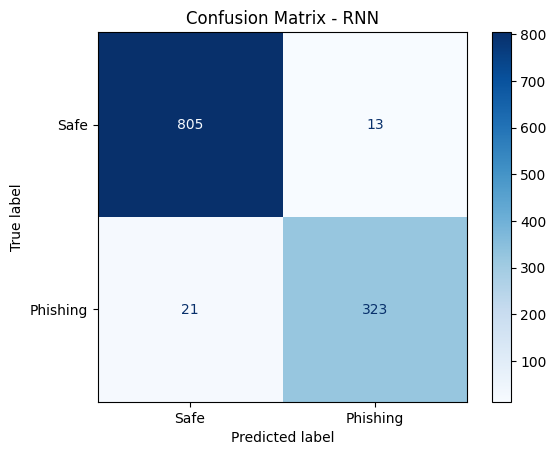

In [23]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Safe", "Phishing"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - RNN")
plt.show()

### LSTM

In [24]:
y_pred = lstm_model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

results = _compute_metrics(y_test, y_pred)

for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 212ms/step
accuracy: 0.9750
precision: 0.9339
recall: 0.9855
f1_score: 0.9590
roc_auc: 0.9781


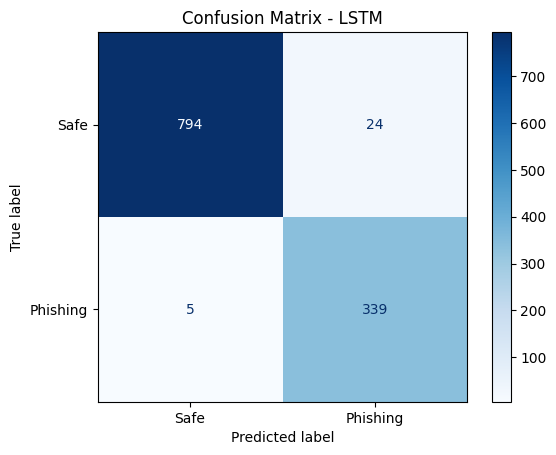

In [25]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Safe", "Phishing"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - LSTM")
plt.show()

### BERT

In [26]:
predictions = bert_trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

results = _compute_metrics(y_true, y_pred)

for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

accuracy: 0.9802
precision: 0.9573
recall: 0.9767
f1_score: 0.9669
roc_auc: 0.9792


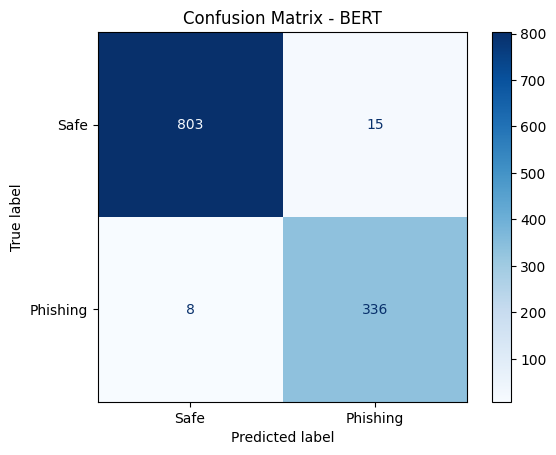

In [27]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Safe", "Phishing"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - BERT")
plt.show()

## Final Results

| Model                 | Accuracy | Precision | Recall | F1-Score | ROC AUC |
|-----------------------|----------|-----------|--------|----------|---------|
| RNN                   | 0.9707   |  0.9613   | 0.9390 | 0.9500   | 0.9615  |
| LSTM                  | 0.9750   |  0.9339   | 0.9855 | 0.9590   | 0.9781  |
| BERT                  | 0.9802   |  0.9573   | 0.9767 | 0.9669   | 0.9792  |